In [1]:
import sys
import os
import toml

import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format

import numpy as np
import scipy.optimize as SciOpt
from scipy.special import rel_entr
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from tqdm.notebook import tqdm
from copy import deepcopy

sys.path.append(os.path.join(sys.path[0], '../..'))

from data.io import Reader
from data.data_generators import DataGenerator
from lsm.lsmtype import Policy
import lsm.cost as CostFunc
import lsm.solver as Solvers

In [2]:
config = Reader.read_config('../../endure.toml')
data_gen = DataGenerator(config)
solver = Solvers.EndureLevelSolver(config)

In [3]:
ewls = config['workloads']
rhos = np.arange(0, 4, 0.5)
ewls

[{'id': 0, 'z0': 0.25, 'z1': 0.25, 'q': 0.25, 'w': 0.25},
 {'id': 1, 'z0': 0.97, 'z1': 0.01, 'q': 0.01, 'w': 0.01},
 {'id': 2, 'z0': 0.01, 'z1': 0.97, 'q': 0.01, 'w': 0.01},
 {'id': 3, 'z0': 0.01, 'z1': 0.01, 'q': 0.97, 'w': 0.01},
 {'id': 4, 'z0': 0.01, 'z1': 0.01, 'q': 0.01, 'w': 0.97},
 {'id': 5, 'z0': 0.49, 'z1': 0.49, 'q': 0.01, 'w': 0.01},
 {'id': 6, 'z0': 0.49, 'z1': 0.01, 'q': 0.49, 'w': 0.01},
 {'id': 7, 'z0': 0.49, 'z1': 0.01, 'q': 0.01, 'w': 0.49},
 {'id': 8, 'z0': 0.01, 'z1': 0.49, 'q': 0.49, 'w': 0.01},
 {'id': 9, 'z0': 0.01, 'z1': 0.49, 'q': 0.01, 'w': 0.49},
 {'id': 10, 'z0': 0.01, 'z1': 0.01, 'q': 0.49, 'w': 0.49},
 {'id': 11, 'z0': 0.33, 'z1': 0.33, 'q': 0.33, 'w': 0.01},
 {'id': 12, 'z0': 0.33, 'z1': 0.33, 'q': 0.01, 'w': 0.33},
 {'id': 13, 'z0': 0.33, 'z1': 0.01, 'q': 0.33, 'w': 0.33},
 {'id': 14, 'z0': 0.01, 'z1': 0.33, 'q': 0.33, 'w': 0.33}]

In [4]:
def create_tunings():
    df = []
    pbar = tqdm(ewls, desc='Workloads')

    for idx, w in enumerate(pbar):
        pbar.set_postfix(workload=w)
        row = {}
        row['workload_idx'] = idx
        z0, z1, q, w = (w['z0'], w['z1'], w['q'], w['w'])
        row['z0'], row['z1'], row['q'], row['w'] = (z0, z1, q, w)
        for key in config['system'].keys():
            row[key] = config['system'][key]

        nominal = solver.find_nominal_design(z0, z1, q, w)
        row['nominal_h'] = h_init = nominal.x[0]
        row['nominal_T'] = T_init = nominal.x[1]
        # row['nominal_Q'] = Q_init = nominal.x[2]
        row['nominal_cost'] = nominal.fun
        row['nominal_msg'] = nominal.message
        for rho in rhos:
            row['rho'] = rho
            # robust = solver.find_robust_design(rho, z0, z1, q, w, [h_init, T_init, Q_init])
            robust = solver.find_robust_design(rho, z0, z1, q, w, [h_init, T_init])
            row['robust_h'] = robust.x[0]
            row['robust_T'] = robust.x[1]
            # row['robust_Q'] = robust.x[2]
            row['robust_msg'] = robust.message
            # row['robust_cost'] = solver.nominal_objective(robust.x[0:3], z0, z1, q, w)
            row['robust_cost'] = solver.nominal_objective(robust.x[0:2], z0, z1, q, w)

            # Append the design to the dataframe
            df.append(deepcopy(row))

    df = pd.DataFrame(df)
    return df

In [5]:
tunings = create_tunings()
tunings

Workloads:   0%|          | 0/15 [00:00<?, ?it/s]

/Users/ndhuynh/miniforge3/lib/python3.9/site-packages/scipy/optimize/_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


,workload_idx,z0,z1,q,w,B,phi,s,E,H,...,N,nominal_h,nominal_T,nominal_cost,nominal_msg,rho,robust_h,robust_T,robust_msg,robust_cost
0,0,0.25,0.25,0.25,0.25,32,1,0.00,8192,10,...,8589934592,4.05,17.85,1.95,Optimization terminated successfully,0.00,4.04,17.89,Optimization terminated successfully,1.95
1,0,0.25,0.25,0.25,0.25,32,1,0.00,8192,10,...,8589934592,4.05,17.85,1.95,Optimization terminated successfully,0.50,1.00,44.87,Optimization terminated successfully,2.17
2,0,0.25,0.25,0.25,0.25,32,1,0.00,8192,10,...,8589934592,4.05,17.85,1.95,Optimization terminated successfully,1.00,1.00,68.38,Optimization terminated successfully,2.36
3,0,0.25,0.25,0.25,0.25,32,1,0.00,8192,10,...,8589934592,4.05,17.85,1.95,Optimization terminated successfully,1.50,1.00,88.45,Optimization terminated successfully,2.52
4,0,0.25,0.25,0.25,0.25,32,1,0.00,8192,10,...,8589934592,4.05,17.85,1.95,Optimization terminated successfully,2.00,1.00,88.45,Optimization terminated successfully,2.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,14,0.01,0.33,0.33,0.33,32,1,0.00,8192,10,...,8589934592,1.00,17.98,2.45,Optimization terminated successfully,1.50,1.00,88.45,Optimization terminated successfully,3.11
116,14,0.01,0.33,0.33,0.33,32,1,0.00,8192,10,...,8589934592,1.00,17.98,2.45,Optimization terminated successfully,2.00,1.00,88.45,Optimization terminated successfully,3.11
117,14,0.01,0.33,0.33,0.33,32,1,0.00,8192,10,...,8589934592,1.00,17.98,2.45,Optimization terminated successfully,2.50,1.00,88.45,Optimization terminated successfully,3.11
118,14,0.01,0.33,0.33,0.33,32,1,0.00,8192,10,...,8589934592,1.00,17.98,2.45,Optimization terminated successfully,3.00,1.00,88.45,Optimization terminated successfully,3.11


In [6]:
tunings.nominal_msg.unique()

array(['Optimization terminated successfully'], dtype=object)

In [7]:
tunings.groupby('workload_idx').get_group(2)

,workload_idx,z0,z1,q,w,B,phi,s,E,H,...,N,nominal_h,nominal_T,nominal_cost,nominal_msg,rho,robust_h,robust_T,robust_msg,robust_cost
16,2,0.01,0.97,0.01,0.01,32,1,0.00,8192,10,...,8589934592,6.35,21.07,1.04,Optimization terminated successfully,0.00,6.35,21.00,Optimization terminated successfully,1.04
17,2,0.01,0.97,0.01,0.01,32,1,0.00,8192,10,...,8589934592,6.35,21.07,1.04,Optimization terminated successfully,0.50,1.00,53.44,Optimization terminated successfully,1.06
18,2,0.01,0.97,0.01,0.01,32,1,0.00,8192,10,...,8589934592,6.35,21.07,1.04,Optimization terminated successfully,1.00,1.00,56.83,Optimization terminated successfully,1.06
19,2,0.01,0.97,0.01,0.01,32,1,0.00,8192,10,...,8589934592,6.35,21.07,1.04,Optimization terminated successfully,1.50,1.00,59.13,Optimization terminated successfully,1.06
20,2,0.01,0.97,0.01,0.01,32,1,0.00,8192,10,...,8589934592,6.35,21.07,1.04,Optimization terminated successfully,2.00,1.00,61.01,Optimization terminated successfully,1.06
21,2,0.01,0.97,0.01,0.01,32,1,0.00,8192,10,...,8589934592,6.35,21.07,1.04,Optimization terminated successfully,2.50,1.00,62.74,Optimization terminated successfully,1.06
22,2,0.01,0.97,0.01,0.01,32,1,0.00,8192,10,...,8589934592,6.35,21.07,1.04,Optimization terminated successfully,3.00,1.00,64.49,Optimization terminated successfully,1.06
23,2,0.01,0.97,0.01,0.01,32,1,0.00,8192,10,...,8589934592,6.35,21.07,1.04,Optimization terminated successfully,3.50,1.00,66.52,Optimization terminated successfully,1.06


In [8]:
OLD_DF = pd.read_csv('/Users/ndhuynh/sandbox/data/workload_uncertainty_tunings.csv')
OLD_DF.groupby('workload_idx').get_group(2)

,workload_idx,z0,z1,q,w,N,phi,B,s,E,...,nominal_cost,nominal_is_leveling_policy,rho,robust_exit_mode,robust_m_h,robust_m_filt,robust_m_buff,robust_T,robust_cost,robust_is_leveling_policy
80,2,0.01,0.97,0.01,0.01,1000000000,1,4,0.00,8192,...,3.57,True,0.00,0,5.00,"5,000,000,000.00","5,000,000,000.00",20.00,4.85,False
81,2,0.01,0.97,0.01,0.01,1000000000,1,4,0.00,8192,...,3.57,True,0.10,0,5.00,"5,000,000,000.00","5,000,000,000.00",20.00,4.85,False
82,2,0.01,0.97,0.01,0.01,1000000000,1,4,0.00,8192,...,3.57,True,0.20,0,5.00,"5,000,000,000.00","5,000,000,000.00",20.00,4.85,False
83,2,0.01,0.97,0.01,0.01,1000000000,1,4,0.00,8192,...,3.57,True,0.30,0,5.00,"5,000,000,000.00","5,000,000,000.00",20.00,4.85,False
84,2,0.01,0.97,0.01,0.01,1000000000,1,4,0.00,8192,...,3.57,True,0.40,0,5.00,"5,000,000,000.00","5,000,000,000.00",20.00,4.85,False
85,2,0.01,0.97,0.01,0.01,1000000000,1,4,0.00,8192,...,3.57,True,0.50,0,5.00,"5,000,000,000.00","5,000,000,000.00",20.00,4.85,False
86,2,0.01,0.97,0.01,0.01,1000000000,1,4,0.00,8192,...,3.57,True,0.60,0,5.00,"5,000,000,000.00","5,000,000,000.00",20.00,4.85,False
87,2,0.01,0.97,0.01,0.01,1000000000,1,4,0.00,8192,...,3.57,True,0.70,0,5.00,"5,000,000,000.00","5,000,000,000.00",20.00,4.85,False
88,2,0.01,0.97,0.01,0.01,1000000000,1,4,0.00,8192,...,3.57,True,0.80,0,5.00,"5,000,000,000.00","5,000,000,000.00",20.00,4.85,False
89,2,0.01,0.97,0.01,0.01,1000000000,1,4,0.00,8192,...,3.57,True,0.90,0,5.00,"5,000,000,000.00","5,000,000,000.00",20.00,4.85,False


# Looking at Robust Tuning Performance

In [9]:
def set_style(fsz=14):
    mpl.rcParams["font.size"] = f'{fsz}'
    plt.rc('axes', titlesize=fsz)
    plt.rc('axes', labelsize=fsz)
    plt.rc('xtick', labelsize=fsz)
    plt.rc('ytick', labelsize=fsz)
    plt.rc('legend', fontsize=fsz)
    plt.rc('figure', titlesize=fsz)
    
def set_size(fig, width=3.33, height=2, scale=1):
    fig.set_size_inches(width * scale, height * scale)
    plt.tight_layout()

In [10]:
def kl_div(w0: np.array, w1: np.array):
    return np.sum(rel_entr(w0, w1)) 

In [11]:
def sample_workloads(samples=10000):
    wls = []
    np.random.seed(0)
    for _ in range(samples):
        wls.append(data_gen._sample_workload(4))
    return wls

In [12]:
def gen_workloads(workload: dict[str, float]) -> pd.DataFrame:
    w0 = np.array([workload[key] for key in ('z0', 'z1', 'q', 'w')])
    samples = sample_workloads()
    distances = []
    for sample in samples:
        distances.append(
            {'workload': sample,
             'rho': kl_div(sample, w0)})
        
    return pd.DataFrame(distances)

In [13]:
def eval_nominal(model, tuning, solver, z0, z1, q, w):
    # Can round if need to
    return solver.nominal_objective(tuning, z0, z1, q, w)

In [14]:
def gen_costs(
    solver: Solvers.EndureSolver,
    w0: dict[str, float],
    samples: list[list[float]],
    tunings: dict[str, dict]
) -> pd.DataFrame:
    df = []
    w0 = np.array([w0[key] for key in ('z0', 'z1', 'q', 'w')])
    for wl in samples:
        z0, z1, q, w = wl
        row = {'rho': kl_div(wl, w0), 'z0': z0, 'z1': z1, 'q': q, 'w': w}
        for name, tuning in tunings.items():
            row[name] = eval_nominal(name, tuning, solver, z0, z1, q, w)
        df.append(row)
    # Special case we will add our orignal workload
    z0, z1, q, w = w0
    row = {'rho': 0, 'z0': z0, 'z1': z1, 'q': q, 'w': w}
    for name, tuning in tunings.items():
        row[name] = eval_nominal(name, tuning, solver, z0, z1, q, w)
    df.append(row)
    return pd.DataFrame(df)

In [25]:
def plot_robust_vs_nominal(wl_idx, rho, log=False, plot_error=False):
    samples = sample_workloads()
    designs = tunings.groupby('workload_idx').get_group(wl_idx)
    designs = designs[designs.rho == rho].squeeze()
    old_designs = OLD_DF.groupby('workload_idx').get_group(wl_idx)
    old_designs = old_designs[old_designs.rho == rho].squeeze()
    designs = {
        # 'Nominal Old': np.array([old_designs.nominal_m_h, old_designs.nominal_T],),
        'Nominal': np.array([designs.nominal_h, designs.nominal_T],),
        'Robust': np.array([designs.robust_h, designs.robust_T]),
        # 'Robust Old': np.array([old_designs.robust_m_h, old_designs.robust_T]),
    }
    _ = [print(d) for d in designs.items()] if log else None
    colors = {'Nominal': 'tab:gray', 'Robust': 'tab:green', 'Nominal Old': 'tab:gray', 'Robust Old': 'tab:green'}
    markers = {'Nominal': 'o', 'Robust': '*'}
    df = gen_costs(solver, ewls[wl_idx], samples, designs)
    
    rho_bins = np.arange(0.0, 4.5, 0.5)
    rho_bins = list(zip(rho_bins, rho_bins[1:]))
    rhos = np.array([0] + [x + (y - x) / 2 for x, y in rho_bins])

    mean = []
    for low, high in rho_bins:
        mean.append(df[(df.rho > low) & (df.rho <= high)].mean().to_dict())
    mean = pd.DataFrame([df.iloc[-1].to_dict()] + mean)
    
    std = []
    for low, high in rho_bins:
        std.append(df[(df.rho > low) & (df.rho <= high)].std().to_dict())
    std = pd.DataFrame([df.iloc[-1].to_dict()] + std)
    if log:
        print(std)
    
    fig, ax = plt.subplots()
    for mode in designs.keys():
        ax.plot(rhos,
                1 / mean[mode],
                label=f'{mode}',
                marker=markers.get(mode, 'x'),
                color=colors.get(mode, 'black'),
                linestyle='dashed' if 'Old' in mode else 'solid')
        if plot_error:
            ax.fill_between(mean['rho'], mean[mode] - std[mode], mean[mode] + std[mode], alpha=0.2, color=colors.get(mode, 'gray'))
    
    w0 = np.array([ewls[wl_idx][key] for key in ('z0', 'z1', 'q', 'w')])
    ax.set_xlabel(f'$I_{{KL}}( \hat{{w}}, w_{{{wl_idx}}})$ | $w_{{{wl_idx}}}$: ({w0[0]:.0%}, {w0[1]:.0%}, {w0[2]:.0%}, {w0[3]:.0%})')
    ax.set_ylabel(r'Avg. I/O Per Query') 
    _ = ax.legend(borderpad=0.3, labelspacing=0.2, ncol=2, columnspacing=0.5, frameon=True).set_zorder(2)
    
    return df, mean, fig, ax

('Nominal', array([ 3.97566268, 17.73149916]))
('Robust', array([ 1.        , 88.45323709]))
   rho   z0   z1    q    w  Nominal  Robust
0 0.00 0.33 0.01 0.33 0.33     2.24    3.00
1 0.13 0.18 0.05 0.18 0.18     0.80    0.65
2 0.14 0.22 0.08 0.22 0.22     1.01    0.81
3 0.14 0.18 0.06 0.18 0.17     0.80    0.63
4 0.15 0.13 0.04 0.14 0.13     0.62    0.49
5 0.14 0.11 0.04 0.10 0.11     0.47    0.39
6 0.14 0.07 0.03 0.08 0.07     0.34    0.26
7 0.15 0.06 0.03 0.05 0.05     0.26    0.22
8 0.15 0.03 0.02 0.03 0.03     0.14    0.12


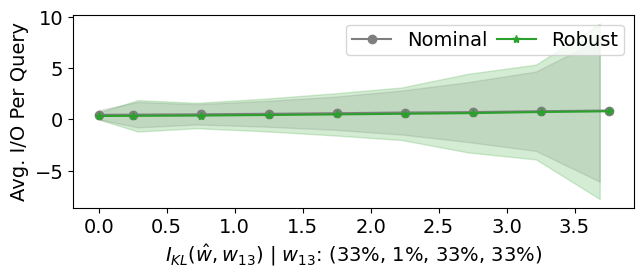

In [26]:
set_style(fsz=14)
df, mean, fig, ax = plot_robust_vs_nominal(13, 2, log=True, plot_error=True)
# ax.set_xticks([0, 1, 2, 3, 4])
set_size(fig, width=2*3.33, height=1.5*2)

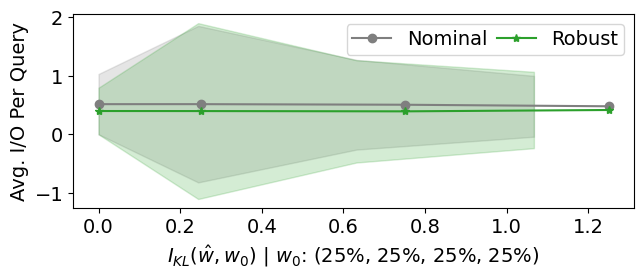

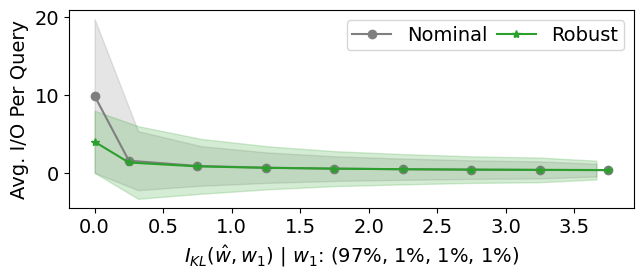

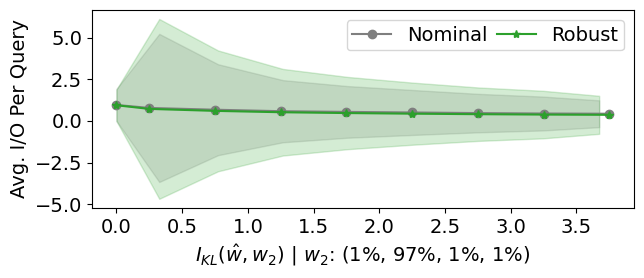

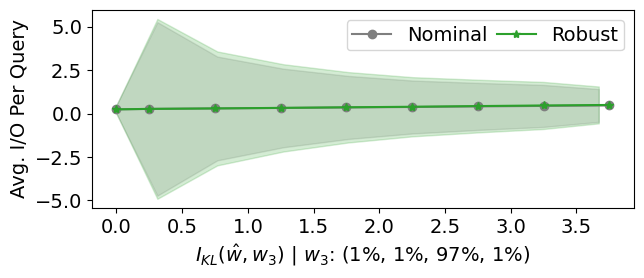

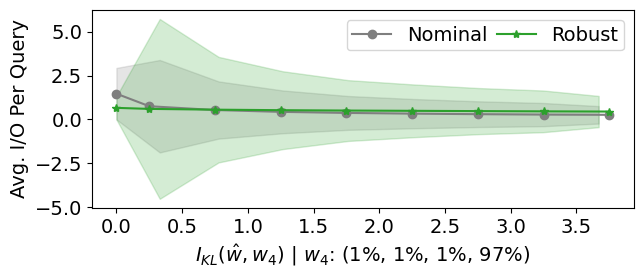

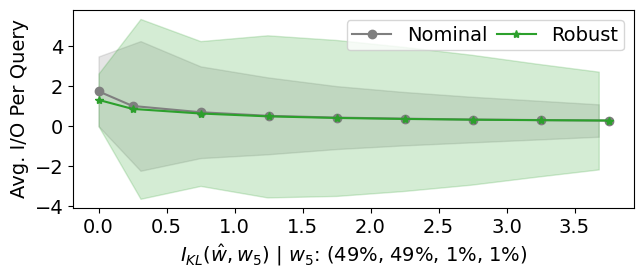

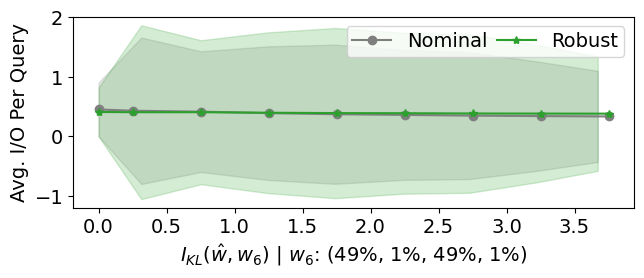

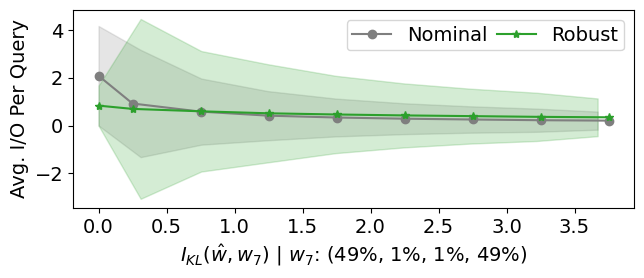

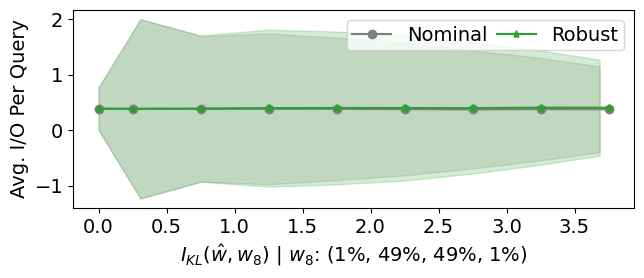

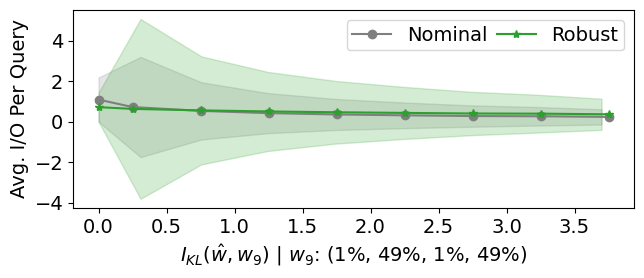

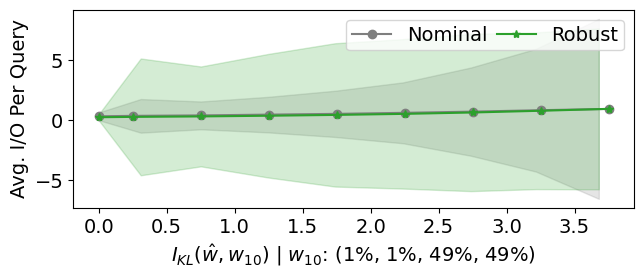

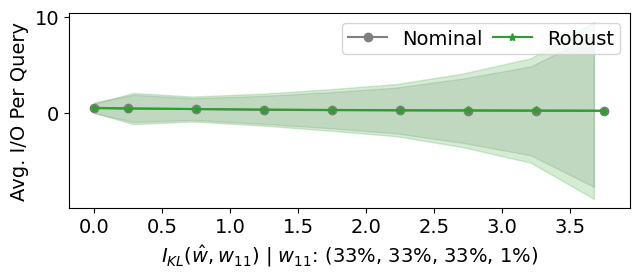

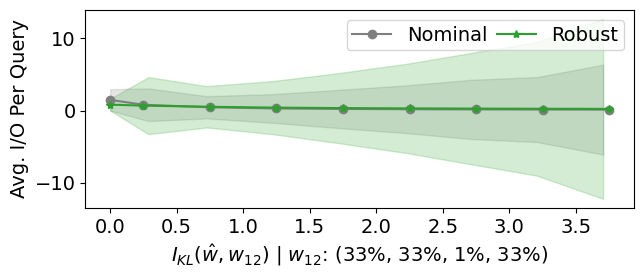

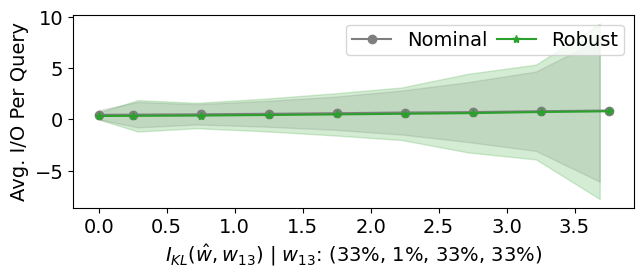

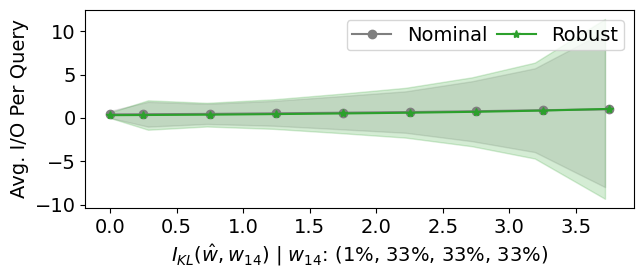

In [27]:
for idx in range(len(ewls)):
    set_style(fsz=14)
    df, mean, fig, ax = plot_robust_vs_nominal(idx, 2, plot_error=True)
    set_size(fig, width=2*3.33, height=1.5*2)

In [18]:
N = 1000000000
phi = 1
s =  0.000001     # Average range query selectivity
B = 4            # Number of entries that fit in a disk page
E = 8192         # Size of data entries in bits
M = 8589934592   # Total memory budget of 1 GiB

In [19]:
M / 8 / 1024 / 1024 / 1024

1.0

In [20]:
(10 * N / 8 / 1024 / 1024 / 1024)

1.1641532182693481